# Traffic and Transport Reliability

````{note}
This page is generated from an `*.ipynb` file which requires several auxiliary files, all of which can be downloaded using the link below.
```{eval-rst}
:download:`Download zip file for this exercise.<exercise_traffic.zip>`
```
````



Have you ever sat in a car during rush hour and been annoyed at the amount of traffic? Have you ever marvelled at the recklessness of fast drivers, watched rubber-neckers gawking at an accident or thought there must be a better way to design this highway? Today you will get a chance to give it a try on your own!

One of the reasons traffic networks are difficult to design is that they must operate well under a wide range of difficult to predict conditions: think of severe weather events, a large number of vehicles on the road during a few key points per day and the unpredictable behavior of human drivers. This all suggests that a stochastic, or probabilistic approach can be well suited to traffic and transport evaluations.

For this assignment you will consider a highway route between Dordrecht and The Hague (we will call this route the ‘trajectory’). You have data measuring travel time along this trajectory during two months, all measured between the hours of 5.00-11.00 (the morning commute), which we will use to estimate the probability that the travel time exceeds some critical threshold, and the threshold itself is determined based on travel time as a risk metric.

## Estimating Traffic Patterns in Practice

Before we begin, note that this exercise is a dramatic simplification of reality, as it uses simplified methods and a single dataset to evaluate one highway trajectory. In practice, this is done by setting up a complex network-based model and using stochastic processes and probability distributions to simulation things like vehicle flow rates, accidents, road closures, etc. Travel times are then described using probability distributions that are based on a large number of simulations.

In other words: assume a distribution of flow rate or vehicles on the road, use stochastic processes to consider the range of highway conditions and the occurrence of accidents, then let the computer do the hard work. In the end you get a histogram of travel times for your trajectory of interest. You can then look at the database of simulations to try and make inference on what leads to undesirable conditions. For example, take the group of simulations with the longest travel times for a given trajectory and see if it is caused by insufficient flow capacity or emergency vehicle response rate (i.e., ability to clear accidents quickly).

In this exercise we will not simulate an entire traffic network, but instead use two simplified methods for estimating travel time, each of which will give different insight into possible design decisions.

## How does this link to MUDE Weeks 2.7-2.8 Risk and Reliability?

This is in fact a relatively simple probabilistic design problem. Just as the simple example for computing dike height to withstand a river discharge with failure probability of 1% (a one random variable case), in this example we need to design the highway such that travel time on the highway only exceeds the threshold amount 5% of the time. In this case the only random variable is vehicle flow rate. As you continue reading, you will probably think the computational models and method for taking into account interventions is a bit complicated, but remember: you only need to design for one random variable!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

## Traffic Variables

We are interested in estimating tavel time, $t$ [minutes], measured along a single highway. Key variables that play a role in determining $t$ for the Dordrecht-Den Haag trajectory are:

- Vehicle flow rate, $q$ [vehicles/hr]: typically measured per link, but for our purposes it will represent the entire highway trajectory. For the morning commute, the flow rate is typically 5500 veh/hr.
- Capacity, $C$ [veh/hr]: the maximum flow rate of a link. For our trajectory, the capacity is 5600 veh/hr.
- Delay, $t_{delay}$ [min]: additional time required to travel a trajectory for a single vehicle. Caused by an accident that lasts $t_{accident}$ minutes.

A few other variables will be described below after we introduce two methods to calculate travel time, but first we will introduce you to the Python code that will be used to make it easy for you to solve this problem!

## `Trajectory` class

As the objective of this exercise is to focus on the probabilistic design process (*not* to see how fast you can use Python), many key steps have been automated for you using a class, `Trajectory`, which is defined in `exercise_setup.py`. An instance of the class is initialized with default values already defined, and many of the methods can be used without the need to specify inputs (see examples below). Observations in the attached `csv` file are also initialized as a dataframe attribute of the class, so you don't even need to import the data. For most methods, making a user-specified input argument will allow you to quickly see how a design decision may modify the characteristics of our highway trajectory. 

An instance is created in the following cell, and the class is used repeatedly throughout this notebook to provide usage examples. We have tried to provide informative docstrings to help figure out what each method does, so you should not have to look in the `exercise_setup.py` file unless you are curious how the class is defined.

In [2]:
from exercise_setup import Trajectory
t=Trajectory()

The class is initialized with a number of default values (explained later), which you can check using the following method:

In [3]:
print(t.print_parameters.__doc__)
t.print_parameters()

Print current values used in Method 1 and 2.
Current parameter values are:
    alpha = 0.15
     beta = 4
      t_0 = 28.5
        C = 5600
      rCf = 0.2
        q = 5500


It's easy to create a second instance of the class, which can be useful if you want to see what the affect of varying parameter values. For example, here we change $q$ from the default value of 5500 to 5000:

In [4]:
t2=Trajectory()
t2.q = 5000
t2.print_parameters()

Current parameter values are:
    alpha = 0.15
     beta = 4
      t_0 = 28.5
        C = 5600
      rCf = 0.2
        q = 5000


## Part 1. Two Methods for Estimating Travel-Time

We will introduce two methods for computing the travel time, one that focuses on *flow rate* and *capacity*, the other on *accident duration.*

### Method 1: Bureau of Public Roads (BPR) Curve

Method 1 computes travel time as a function of vehicle flow rate, $q$:

$$t\left(q\right)=t^0\left(1+\alpha\left(\frac{q}{C}\right)^\beta\right)$$

where $t^0$ is the free flow travel time, which is the time it would take to travel the link if there were no other vehicles on the road ($q=0$).

$\alpha=0.15$ and $\beta=4.0$ are constants, especially for our simple case.

Later in the exercise we will make changes to the highway (interventions) that will influence the parameters $q$ and $C$ and $t^0$. For example, adding a lane to the highway will increase $C$.

Method 1 has been implemented in the `Trajectory` class as `travel_time_method_1()`.

In [5]:
print(t.travel_time_method_1.__doc__)

Compute travel time with Method 1.
        
        Keyword arguments: q, alpha, beta, t_0, C.
        Returns: travel time as float or array, depending on input.
        


We can use it to calculate the travel time for given variables.

In [6]:
print(f'Travel time computed with Method 1 = '
      f'{t.travel_time_method_1():.1f} minutes.')

Travel time computed with Method 1 = 32.5 minutes.


You can use *keyword arguments* to change the default values for capacity, free-flow travel time and flow rate to see how the estimated travel-time changes!

In [7]:
print(f'Travel time computed with Method 1 = '
      f'{t.travel_time_method_1(C=6000):.1f} minutes.')

Travel time computed with Method 1 = 31.5 minutes.


In [8]:
print(f'Travel time computed with Method 1 = '
      f'{t.travel_time_method_1(q=3000):.1f} minutes.')

Travel time computed with Method 1 = 28.9 minutes.


Using sliders we can look at the effect of capacity and t_0 on the BPR curve.

```{note}
The widgets displayed on this page will not work in the website version, only when you use the `*.ipynb` file with a Python kernel (e.g., in Jupyter Notebook or Jupyter Lab).
```

In [9]:
from custom_widgets import method_1

interactive(children=(FloatSlider(value=28.5, description='t_0', max=32.0, min=26.0, step=0.5), FloatSlider(va…

### Method 2: Delays Caused by Accidents

This method takes into account accidents that may have occurred along our trajectory computing the delay experienced by a single vehicle, $t_\mathrm{delay}$. The delay is related to the length of the accident itself, as well as the traffic flow and trajectory capacity:

$$t_\mathrm{delay}=t_{\mathrm{accident}} \cdot \frac{(q - rC)}{2q}$$

Where $rC$ is the remaining capacity of the link [veh/hr], approximated as a percentage of the link capacity:

$$rC = rC_f \cdot C$$

In our case we assume $rC_f$=0.2.

Total travel time along the trajectory can be estimated by adding $t_{delay}$ to the travel time without accidents. This is similar to the free flow travel time, $t^0$, except we must take into account the fact that accidents don't have a significant effect on travel time until traffic flow is already reaching the trajectory capacity. Thus, we introduce a cutoff time, $t_{cutoff}$, above which accidents affect $t$:

$$t=t_{\mathrm{cutoff}}+t_\mathrm{delay}$$

The value of $t_{cutoff}$ is estimated using Method 1 for a condition close to the capacity of the highway---100 veh/hr less---which returns 32.5 min, computed here:.

In [10]:
print(f'Travel time for q = {t.q} and C = {t.C} using Method 1: '
      f'{t.travel_time_method_1(q=t.q, C=t.C):.2f} min')

Travel time for q = 5500.0 and C = 5600.0 using Method 1: 32.50 min


Method 2 has been implemented in the `Trajectory` class as `travel_time_method_2()`, which computes travel time for a single vehicle and a single accident. The class also assumes $t_{accident}=10$ min as a default value, which is close to the median accident length during the morning commute. 

In [11]:
print(t.travel_time_method_2.__doc__)

Compute travel time with Method 2 (delays).
        
        Keyword arguments: t_accident, q, C, rCf, t_cutoff.
        Returns: travel time as float or array, depending on input.
        


We can use it to calculate the travel time for given variables, which is set up to assume that a single 10 min accident has occured for a vehicle traveling the trajectory.

In [12]:
print(f'Travel time computed with Method 2 = '
      f'{t.travel_time_method_2():.1f} minutes.')

A single accident duration of 10 min is assumed by default. Include argument t_accident=? to override.
Travel time computed with Method 2 = 36.5 minutes.


Investigating the effect of accident duration is easy because you can change the default argument values just like for Method 1 (see documentation for complete list of input arguments):

In [13]:
try_t_accident = 30
print(f'Travel time computed with Method 2 = '
      f'{t.travel_time_method_2(t_accident=try_t_accident):.1f} '
      f'minutes when accident time is {try_t_accident} min.')

Travel time computed with Method 2 = 44.4 minutes when accident time is 30 min.


There is also a method to compute delay:

In [14]:
print(f'The delay for one vehicle is '
      f'{t.estimate_t_delay():.2f} min.')
print(f'The delay for one vehicle due to a {try_t_accident} min '
      f'accident is {t.estimate_t_delay(t_accident=try_t_accident):.2f} min.')

A single accident duration of 10 min is assumed by default. Include argument t_accident=? to override.
The delay for one vehicle is 3.98 min.
The delay for one vehicle due to a 30 min accident is 11.95 min.


Interesting, the previous calculation shows that if the accident time increases by 20 min, the delay is only increased by 8 min.

```{note}
The widgets displayed on this page will not work in the website version, only when you use the `*.ipynb` file with a Python kernel (e.g., in Jupyter Notebook or Jupyter Lab).
```

In [15]:
from custom_widgets import method_2

interactive(children=(FloatSlider(value=10.0, description='t_accident', max=60.0, min=5.0, step=5.0), FloatSli…

## Part 2. Importing the Data

Here we do 'the usual': import data using pandas, clean it up and explore it with a few summary statistics and visualizations. Luckily we've already done this for you in the `process_observations` method in the `Trajectory` class, and class is initialized with the datafram as an attribute.

In [16]:
print(t.process_observations.__doc__)

Create dataframe with observations.
        
        Steps:
          - Import file defined by string attribute observations_filename.
          - Extract all columns with observations.
          - Set up and return new dataframe:
              - travel_time_df
          - Set up and return new arrays:
              - travel_time
              - flow_rate
              - t_accident
          - dataframe and arrays are added as attributes in init
        


In [17]:
t.travel_time_df.head()

,Travel Time
0,30.144795
1,30.064739
2,29.912339
3,29.972393
4,30.084815


In [18]:
t.travel_time_df.describe()

,Travel Time
count,22021.000000
mean,34.344555
std,9.524935
min,28.524847
25%,30.146187
50%,31.284827
75%,34.625918
max,129.301866


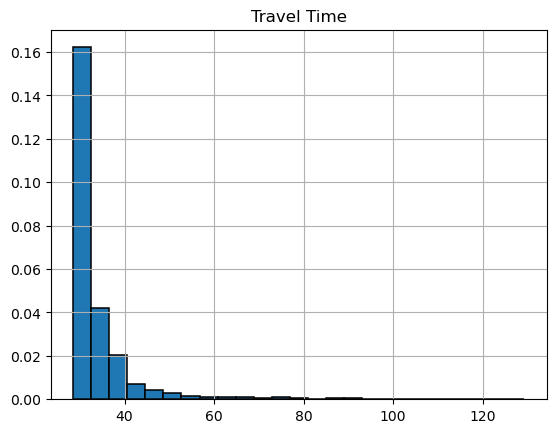

In [19]:
hist = t.travel_time_df.hist(density=True,
                                    bins = 25,
                                    edgecolor='k',
                                    linewidth=1.1)


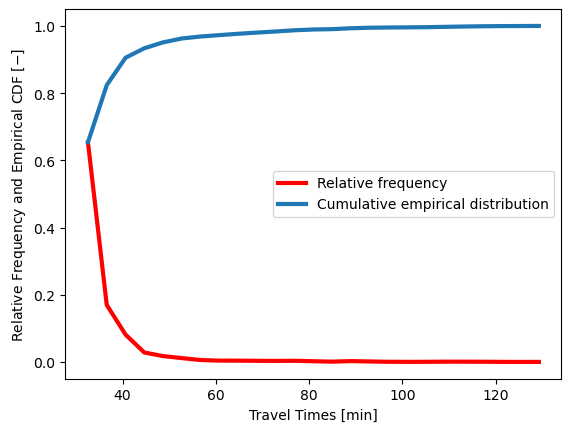

In [20]:
bin_count, bin_position = np.histogram(t.travel_time_df, bins=25)
travel_time_freq = bin_count / sum(bin_count)
travel_time_cdf = np.cumsum(travel_time_freq)
plt.plot(bin_position[1:], travel_time_freq, color="red",
         linewidth=3, label="Relative frequency")
plt.plot(bin_position[1:], travel_time_cdf,
         label="Cumulative empirical distribution", linewidth=3)
plt.xlabel('Travel Times [min]')
plt.ylabel('Relative Frequency and Empirical CDF [$-$]')
plt.legend();

Text(0, 0.5, 'Empirical Exceedance CDF')

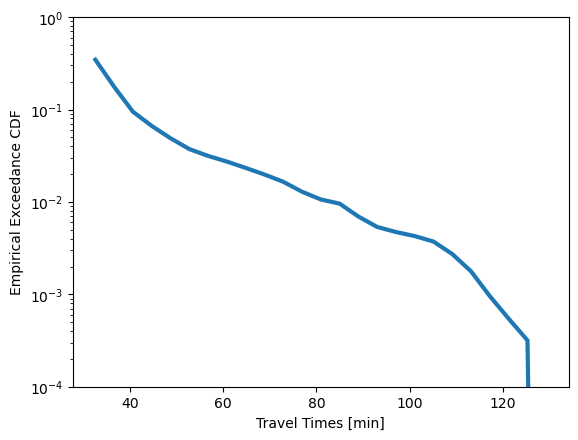

In [21]:
plt.plot(bin_position[1:], 1-travel_time_cdf, label="CDF", linewidth=3)
plt.yscale('log')
plt.ylim([1e-4, 1]);
plt.xlabel('Travel Times [min]')
plt.ylabel('Empirical Exceedance CDF')

## Part 3. Fitting a Burr-Distribution to the Data

It turns out the Burr distribution often is a good fit for traffic flow rate data, and we can obtain the parameters using MLE incorporated in the `scipy.stats` method [`Burr12`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.burr12.html).

The standardized form of the Burr12 distribution (with location, `loc` = 0 and `scale` = 1) is:

$$
f(x, c, d)=c d \frac{x^{c-1}}{\left(1+x^{c}\right)^{d+1}}
$$

The distribution has to be shifted and scaled to fit our data, which is done with the location and scale parameters that are returnd by the method in `scipy`. If the Burr distribution as shown in the introductory video is a two-parameter formulation, and if it is used with the location and scale parameters as follows, it is equivalent to the `scipy` formulation (four parameters):

$$
f_{scipy}(x, c, d, \mathrm{loc}, \mathrm{scale}) = f_{video}(\frac{x-\mathrm{loc}}{\mathrm{scale}}, c, d) \cdot \mathrm{scale}
$$

The CDF of the Burr distribution is very easy to evaluate:
$$
F(x,c, d, \mathrm{loc}, \mathrm{scale})=1−(1+x^c)^{-k}
$$

*NB:*
- *In the video the parameters loc and scale are a and b, respectively. c and k are used equivalently.*
- *You are asked to make a calculation with the CDF below, one of the few things you are required to code on your own in this notebook.*
- *There are actually twelve Burr distributions (yes, 12!). They were 'invented' in the 1940's to avoid tedious hand calculations easier. The scipy distribution is equation 12 from [Burr's 1942 paper "Cumulative Frequency Functions,"](https://doi.org/10.1093%2Fbiomet%2F64.1.129) hence the name*

In `Trajectory`, the distribution is fit during initialization of the class with `fit_burr`, and the parameter values can be printed using `print_parameters_burr`. The example below illustrates the use of `scipy.stats.Burr12` without requiring to dig into the py file.

In [22]:
t.print_parameters_burr()

Parameters are:
    c  = 84.137
    k  = 6.421e-02
   loc = 12.00
 scale = 17.49


Now we will plot the distribution with the histogram to check the fit visually. The PDF is calculated two ways: one using the 4-parameter version provided by `scipy.stats`, the other using the shifted and scaled 2 parameter version. It is clear that the restuls are identical.

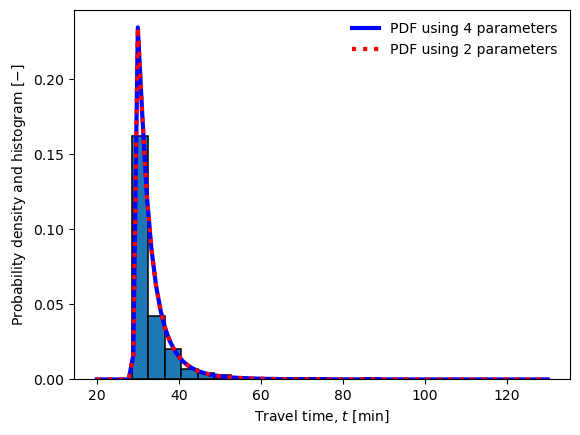

In [23]:
# Plot the distribution and the histogram
from scipy import stats
from scipy.stats import burr12
c, k, loc, scale = t.burr_parameters
x = np.linspace(20,130, 100)
plt.plot(x, burr12.pdf(x, c, k, loc, scale),
         'b-', lw=3, label='PDF using 4 parameters')
plt.plot(x, burr12.pdf((x-loc)/scale, c, k, 0, 1)/scale,
         'r:', lw=3, label='PDF using 2 parameters')
plt.hist(t.travel_time_df,density=True, bins=25,
         edgecolor='k', linewidth=1.1)
plt.legend(loc='best', frameon=False)
plt.xlabel('Travel time, $t$ [min]')
plt.ylabel('Probability density and histogram [$-$]')
plt.show()

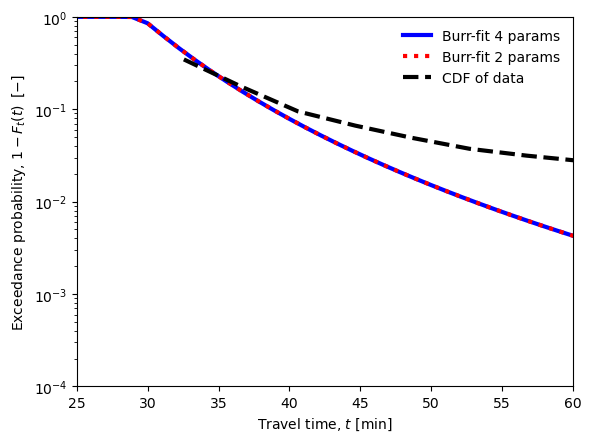

In [24]:
#Burr fit on the data with 4 parameters (red) and with 2 parameters (blue)
fig, ax = plt.subplots(1, 1)
ax.plot(x, 1 - burr12.cdf(x, c, k, loc, scale),
        'b-', lw=3, label='Burr-fit 4 params')
ax.plot(x, 1 - burr12.cdf((x-loc)/scale, c, k, 0, 1),
        'r:', lw=3, label='Burr-fit 2 params')
ax.plot(bin_position[1:], 1 - travel_time_cdf,
        'k--', lw=3, label="CDF of data")
ax.legend(loc='best', frameon=False)
plt.yscale('log')
plt.xlim([25, 60])
plt.ylim([1e-4, 1])
plt.xlabel('Travel time, $t$ [min]')
plt.ylabel('Exceedance probability, $1-F_t(t)\:$ [$-$]')
plt.show()

What do you think of the fit?

## Part 4. Evaluating the Trajectory

The requirement for the trajectory is that the 95 percentile value is no more than 10 minutes longer than the free-flow travel time:

$$
t_{95} \leq t_0 + 10\: \mathrm{min}
$$

**Using the information provided above, compute the 95th percentile of the Burr distribution in the cell below.**

In [25]:
burr_95th_percentile = None

**Use this cell to check whether the trajectory meets the requirement, after you compute the 95th percentile above.**

In [26]:
if burr_95th_percentile is None:
    print('Replace the variable in the cell above with your calculation!')
elif burr_95th_percentile > t.t_0 + 10:
    print('The requirement is not met, interventions are needed.')
elif burr_95th_percentile < 0:
    print('The trajectory meets the requirement.')
elif burr_95th_percentile < t.t_0 + 10:
    print('The trajectory meets the requirement.')

Replace the variable in the cell above with your calculation!


## Part 5. Effect of Interventions on Travel Time

Now it's time for the fun part: let's look at a variety of interventions and see if we can improve the travel time on this highway trajectory! The following sections describe the interventions and illustrate the Python tools that are available for you to re-design the highway.

## Description of Intervention Effects

The following interventions can be considered for our trajectory:

1. **Extra Lane:** widens existing road by one or two lanes  
2. **Hard Shoulder:** adds a hard shoulder to the existing trajectory, providing extra capacity, especially during peak flow moments  
3. **Max Speed:** sets the maximum allowed speed on trajectory (current value, 130 km/h; maximum value: 170km/h)
4. **Alternate Trajectory:** constructs one or two alternative trajectory options (e.g. a second highway or large road), decreasing peak flow rate on the original trajectory  
5. **Incident Management:** speeds up towing and accident clean-up services by X% which reduces time duration of an accident  
6. **Accident Risk Reduction:** employs cooperative intelligent transport systems, C-ITS (vehicle to vehicle communication), to reduce the number of incidents by X%. For our case it can also include a number of measures such as smart signs, lights and lane control.  
7. **Modal Shift, Trucks:** decreases the number of trucks during the morning commute by X% by promoting alternative modes and commute times for truck transport  
8. **Modal Shift, Cars:** equivalent to the above intervention, but for cars  

## Implementation of Intervention Effects

The following table indicates which Method can take into account each intervention and how, as well as key information for using the Python tools:

| No. | Intervention | Variable | Method 1 | Method 2 | Keyword Argument | Values |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| 1 | Extra Lane | $C$ | X | X | `extra_lane` | `None`, 1, 2 |
| 2 | Hard Shoulder | $C$ |  | X | `hard_shoulder` | `True`/`False` |,
| 3 | Max. Speed | $t_0$ | X | X | `max_speed` | >0, 170 max |
| 4 | Alternate trajectory | $q$ | X | X | `alt_route` | `None`, 1, 2 |
| 5 | Incident Management | $t_{accident}$ |  | X | `incident_management` | 1%$-$100% |
| 6 | Accident Risk Reduction | $t_{accident}$ |  | X | `accident_risk_reduction` |1%$-$100%  |
| 7 | Modal Shift, Trucks | $q$ | X | X | `modal_shift_trucks` | 0%$-$20% |
| 8 | Modal Shift, Cars | $q$ | X | X | `modal_shift_cars` | 0%$-$20% |



### Method 1: BPR

The expected travel time changes when the free-flow travel time ($t_0$), flow ($q$) and capacity $C$ are modified. The interventions listed above have been implemented as keyword arguments in the method `intervention_method_1`, illustrated with an example below the docstring:

In [27]:
print(t.travel_time_method_1.__doc__)

Compute travel time with Method 1.
        
        Keyword arguments: q, alpha, beta, t_0, C.
        Returns: travel time as float or array, depending on input.
        


In [28]:
travel_time_baseline = t.travel_time_method_1()
travel_time_with_intervention = t.intervention_method_1(max_speed=150)
print(f'The baseline travel time is '
      f'{travel_time_baseline:0.2f} min')
print(f'The travel time with an intervention is '
      f'{travel_time_with_intervention:0.2f} min'
      f'\n    (the difference is '
      f'{travel_time_with_intervention - travel_time_baseline:.2f} min)')

The baseline travel time is 32.50 min
The travel time with an intervention is 28.17 min
    (the difference is -4.33 min)


The Burr distribution can also be estimated for the same intervention using `plot_distribution_method_1`, which relies on `intervention_method_1`. Here it is set up with widgets to let you play with the effect of each intervention:

```{note}
The widgets displayed on this page will not work in the website version, only when you use the `*.ipynb` file with a Python kernel (e.g., in Jupyter Notebook or Jupyter Lab).
```

In [29]:
from custom_widgets import method_1_interv_dist

interactive(children=(Dropdown(description='1: Extra Lanes', options=(('None', None), ('1', 1), ('2', 2)), val…

This function will compute the 95th percentile for the baseline parameter values:

In [30]:
print(f'{t.burr_ppf_with_int_1(0.95):.3}')

42.5


The same function allows you to check out how the 95th percentile changes by applying interventions.

*What interventions could you apply in order to meet the requirement for the trajectory?*


In [31]:
print(f'{t.burr_ppf_with_int_1(0.95,alt_route=1):.3}')

33.4


### Method 2: Delays

Interventions for Method two have been implemented as keyword arguments in the method `intervention_method_2`, and can be used the same as with those for Methods 1, although there are 8 possible interventions instead of 5:

In [32]:
print(t.travel_time_method_2.__doc__)

Compute travel time with Method 2 (delays).
        
        Keyword arguments: t_accident, q, C, rCf, t_cutoff.
        Returns: travel time as float or array, depending on input.
        


```{note}
The widgets displayed on this page will not work in the website version, only when you use the `*.ipynb` file with a Python kernel (e.g., in Jupyter Notebook or Jupyter Lab).
```

In [33]:
from custom_widgets import method_2_interv_dist

interactive(children=(Dropdown(description='1: Extra Lanes', options=(('None', None), ('1', 1), ('2', 2)), val…

## Part 6. Cost-Benefit Analysis

Now it's time for the fun part: coming up with an optimal design! It's easy to use the intervention functions introduced above to find a combination that gives a 95th percentile value that meets the requirement. However, in real life interventions cost money, and we will take that into account here using the costs specified in the table, which have also been implemented for you in the methods below, `benefit_cost_method_x`. These functions work with keyword arguments, just like the intervention functions above. With that, the assignment is simply:

**Maximize the ratio of benefits to cost such that: 1) the maximum cost of 250 FCoins is not exceeded, and 2) the 95th percentile is less than $t_0+10$.** Your 'answer' should be in the form of a specific set of interventions (using keyword argument values), costs, benefit-cost ratio, and a short justification for how you came to the result.

Although the assignment is simple, there are a few things to note, in particular: Method 1 and 2 are different, and *both* are simplified versions of reality. They will give you different results because they are different methods, not only because Method 2 includes more interventions. In addition, the costs are defined in terms of FCoins, which are not 'real' monetary units, and have not been scaled to reality; as such, the benefit-cost ratio will does not need to be greatere than 1 to be a viable project.

| Intervention | Keyword Argument | Costs (FCoins) |
| :--- | :---: | :---: |
| New Alternative Route         | `alt_trajectory` | --- |
| 1 lane                       | --- | 150 |
| 2 lanes                      | --- | 180 |
| New Lane                      | `extra_lane` | --- |
| 1 additional lane            | --- | 70 |
| 2 additional lanes           | --- | 100 |
| Create Hard Shoulder          | `hard_shoulder` | 60 |
| Increase Max Speed            | `max_speed` | 7/percent |
| Accident Risk Reduction | `accident_risk_reduction` | 5/percent |
| Incident Management           | `incident_management` | 2/percent |
| Modal Shift Trucks            | `modal_shift_trucks` | 5/percent |
| Modal Shift Cars              | `modal_shift_cars` | 8/percent |

NB: *the "/percent" cost is determined per percent change in the intervention basedo on the pre-intervention value. For example, changing the maximum speed from 130 to 140 km/hr is a +8% change, thus it would cost 56 FCoins*

In [34]:
from benefit_cost import benefit_cost_method_1
from benefit_cost import benefit_cost_method_2

These functions compute the benefit to cost ratio, which you need to maximize without exceeding the total cost.

In [35]:
BC1 = benefit_cost_method_1(modal_shift_trucks=20)

The benefit-cost ratio using Method 1 is: 0.095
Total cost for all interventions applied: 100.000 FCoins


In [36]:
BC2 = benefit_cost_method_2(modal_shift_trucks=20)

The benefit-cost ratio using Method 2 is: -0.058
Total cost for all interventions applied: 100.000 FCoins


Good luck!